In [1]:
from inception_resnet_v1_lcl import *
 
from functools import partial
from keras.models import Model
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import MaxPooling2D
from keras.layers import add
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_model = InceptionResNetV1(input_shape=(224, 224, 3),
                               dropout_keep_prob=0.8)

In [3]:
base_model = InceptionResNetV1(weights_path='./facenet_keras_weights.h5',
                               input_shape=(224, 224, 3),
                               dropout_keep_prob=0.8)

In [4]:
for layer in base_model.layers[:]:
    layer.trainable = False
    
base_model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 111, 111, 32) 96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 111, 111, 32) 0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

add_38 (Add)                    (None, 5, 5, 1792)   0           Block8_2_Activation[0][0]        
                                                                 lambda_38[0][0]                  
__________________________________________________________________________________________________
Block8_3_Activation (Activation (None, 5, 5, 1792)   0           add_38[0][0]                     
__________________________________________________________________________________________________
Block8_4_Branch_1_Conv2d_0a_1x1 (None, 5, 5, 192)    344064      Block8_3_Activation[0][0]        
__________________________________________________________________________________________________
Block8_4_Branch_1_Conv2d_0a_1x1 (None, 5, 5, 192)    576         Block8_4_Branch_1_Conv2d_0a_1x1[0
__________________________________________________________________________________________________
Block8_4_Branch_1_Conv2d_0a_1x1 (None, 5, 5, 192)    0           Block8_4_Branch_1_Conv2d_0a_1x1_B
__________

In [5]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_2
1 Conv2d_1a_3x3
2 Conv2d_1a_3x3_BatchNorm
3 Conv2d_1a_3x3_Activation
4 Conv2d_2a_3x3
5 Conv2d_2a_3x3_BatchNorm
6 Conv2d_2a_3x3_Activation
7 Conv2d_2b_3x3
8 Conv2d_2b_3x3_BatchNorm
9 Conv2d_2b_3x3_Activation
10 MaxPool_3a_3x3
11 Conv2d_3b_1x1
12 Conv2d_3b_1x1_BatchNorm
13 Conv2d_3b_1x1_Activation
14 Conv2d_4a_3x3
15 Conv2d_4a_3x3_BatchNorm
16 Conv2d_4a_3x3_Activation
17 Conv2d_4b_3x3
18 Conv2d_4b_3x3_BatchNorm
19 Conv2d_4b_3x3_Activation
20 Block35_1_Branch_2_Conv2d_0a_1x1
21 Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm
22 Block35_1_Branch_2_Conv2d_0a_1x1_Activation
23 Block35_1_Branch_1_Conv2d_0a_1x1
24 Block35_1_Branch_2_Conv2d_0b_3x3
25 Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm
26 Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm
27 Block35_1_Branch_1_Conv2d_0a_1x1_Activation
28 Block35_1_Branch_2_Conv2d_0b_3x3_Activation
29 Block35_1_Branch_0_Conv2d_1x1
30 Block35_1_Branch_1_Conv2d_0b_3x3
31 Block35_1_Branch_2_Conv2d_0c_3x3
32 Block35_1_Branch_0_Conv2d_1x1_BatchNorm
33 Block35_1_B

In [6]:
classes = 3
epochs = 100
targetx = 224
targety = 224

x = base_model.get_layer(index=442).output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu',  kernel_initializer='he_normal', bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(classes, activation='softmax')(x)

my_model = Model(inputs=base_model.input, outputs=predictions)

my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 111, 111, 32) 96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 111, 111, 32) 0           Conv2d_1a_3x3_BatchNorm[0][0]    
______________________________________________________________________________________________

In [7]:
for i, layer in enumerate(my_model.layers):
    print(i,layer.name)

0 input_2
1 Conv2d_1a_3x3
2 Conv2d_1a_3x3_BatchNorm
3 Conv2d_1a_3x3_Activation
4 Conv2d_2a_3x3
5 Conv2d_2a_3x3_BatchNorm
6 Conv2d_2a_3x3_Activation
7 Conv2d_2b_3x3
8 Conv2d_2b_3x3_BatchNorm
9 Conv2d_2b_3x3_Activation
10 MaxPool_3a_3x3
11 Conv2d_3b_1x1
12 Conv2d_3b_1x1_BatchNorm
13 Conv2d_3b_1x1_Activation
14 Conv2d_4a_3x3
15 Conv2d_4a_3x3_BatchNorm
16 Conv2d_4a_3x3_Activation
17 Conv2d_4b_3x3
18 Conv2d_4b_3x3_BatchNorm
19 Conv2d_4b_3x3_Activation
20 Block35_1_Branch_2_Conv2d_0a_1x1
21 Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm
22 Block35_1_Branch_2_Conv2d_0a_1x1_Activation
23 Block35_1_Branch_1_Conv2d_0a_1x1
24 Block35_1_Branch_2_Conv2d_0b_3x3
25 Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm
26 Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm
27 Block35_1_Branch_1_Conv2d_0a_1x1_Activation
28 Block35_1_Branch_2_Conv2d_0b_3x3_Activation
29 Block35_1_Branch_0_Conv2d_1x1
30 Block35_1_Branch_1_Conv2d_0b_3x3
31 Block35_1_Branch_2_Conv2d_0c_3x3
32 Block35_1_Branch_0_Conv2d_1x1_BatchNorm
33 Block35_1_B

In [8]:
#making the instance of 'ImageDataGenerator' 
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# setting the path of datasets
train_dir = os.getcwd()+"/img/train"
val_dir = os.getcwd()+"/img/val"

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size=20, 
                                                    target_size=(targetx, targety),
                                                    shuffle=True,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                batch_size=10, 
                                                target_size=(targetx, targety),
                                                shuffle=True,
                                                class_mode='categorical')

Found 163 images belonging to 3 classes.
Found 20 images belonging to 3 classes.


In [9]:
#setting ModelCheckpoint
checkpoint_dir = os.getcwd()+"/model"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint = ModelCheckpoint(filepath=checkpoint_dir+"/"+"weight_1.hdf5",
                            monitor='loss',
                            mode='min',
                            save_best_only=True)
 
#compiling
optimizer = Adam(lr=0.0001)
loss = "categorical_crossentropy"
 
my_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])
 
#training
history = my_model.fit(train_generator,
                                 steps_per_epoch=len(train_generator),
                                 epochs=epochs,
                                 validation_data=val_generator, 
                                 validation_steps=len(val_generator),
                                 callbacks=[checkpoint])

Epoch 1/100
9/9 [==============================] - 27s 2s/step - loss: 2.2753 - accuracy: 0.3314 - val_loss: 1.0599 - val_accuracy: 0.4000
Epoch 2/100
9/9 [==============================] - 16s 2s/step - loss: 1.9142 - accuracy: 0.3456 - val_loss: 1.0113 - val_accuracy: 0.5000
Epoch 3/100
9/9 [==============================] - 16s 2s/step - loss: 1.2510 - accuracy: 0.4965 - val_loss: 0.9847 - val_accuracy: 0.5500
Epoch 4/100
9/9 [==============================] - 14s 2s/step - loss: 1.4262 - accuracy: 0.4771 - val_loss: 0.9570 - val_accuracy: 0.5000
Epoch 5/100
9/9 [==============================] - 12s 1s/step - loss: 0.9768 - accuracy: 0.6340 - val_loss: 0.9315 - val_accuracy: 0.5500
Epoch 6/100
9/9 [==============================] - 12s 1s/step - loss: 1.1688 - accuracy: 0.6030 - val_loss: 0.9121 - val_accuracy: 0.5500
Epoch 7/100
9/9 [==============================] - 12s 1s/step - loss: 0.6468 - accuracy: 0.7576 - val_loss: 0.8918 - val_accuracy: 0.5000
Epoch 8/100
9/9 [==========

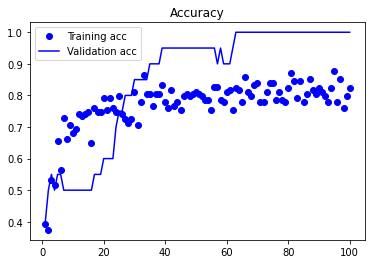

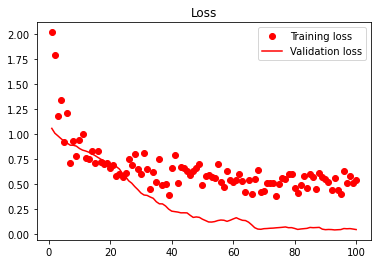

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

### 학습 결과 확인하기

In [11]:
# 모델 불러오기

import os
from keras.models import load_model

checkpoint_dir = os.getcwd()+"/model/"
model = load_model(checkpoint_dir+"weight_1.hdf5")

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 111, 111, 32) 96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 111, 111, 32) 0           Conv2d_1a_3x3_BatchNorm[0][0]    
______________________________________________________________________________________________

모델의 예측 :  최예나
예나 : 99%
유리 : 0%
채원 : 0%


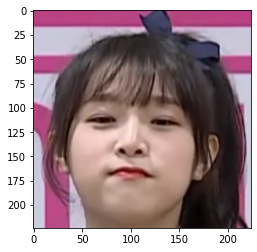

모델의 예측 :  김채원
예나 : 0%
유리 : 2%
채원 : 97%


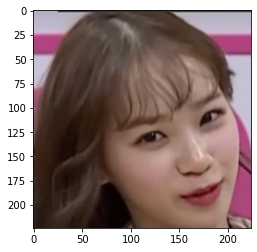

모델의 예측 :  김채원
예나 : 0%
유리 : 0%
채원 : 99%


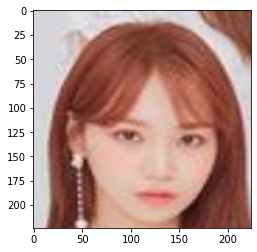

모델의 예측 :  김채원
예나 : 0%
유리 : 6%
채원 : 93%


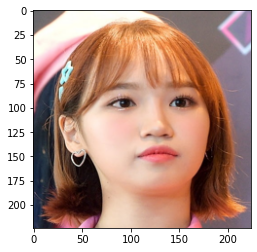

모델의 예측 :  김채원
예나 : 5%
유리 : 2%
채원 : 92%


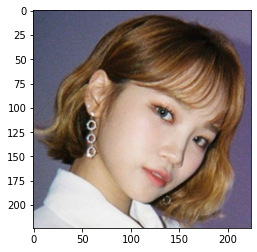

모델의 예측 :  최예나
예나 : 99%
유리 : 0%
채원 : 0%


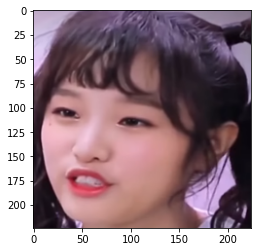

모델의 예측 :  최예나
예나 : 99%
유리 : 0%
채원 : 0%


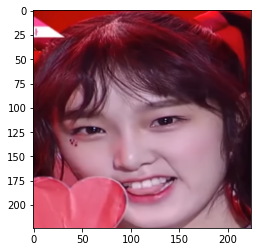

모델의 예측 :  조유리
예나 : 0%
유리 : 99%
채원 : 0%


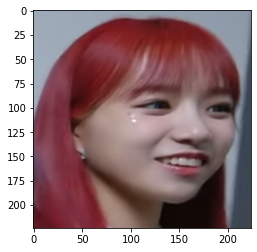

모델의 예측 :  최예나
예나 : 99%
유리 : 0%
채원 : 0%


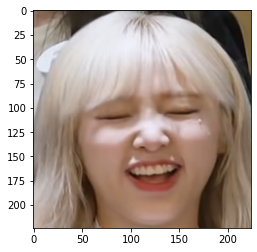

모델의 예측 :  조유리
예나 : 0%
유리 : 97%
채원 : 2%


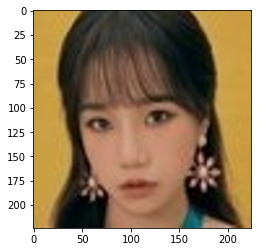

모델의 예측 :  김채원
예나 : 0%
유리 : 0%
채원 : 99%


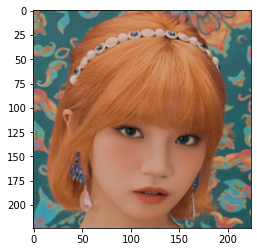

모델의 예측 :  조유리
예나 : 0%
유리 : 99%
채원 : 0%


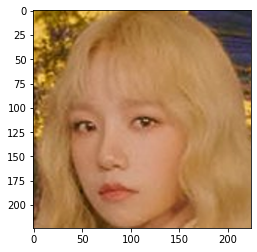

모델의 예측 :  최예나
예나 : 92%
유리 : 7%
채원 : 0%


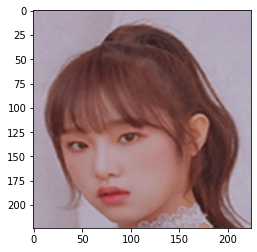

모델의 예측 :  최예나
예나 : 98%
유리 : 1%
채원 : 0%


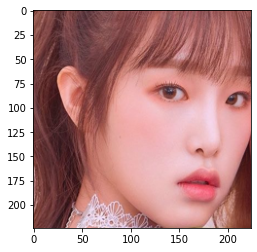

모델의 예측 :  최예나
예나 : 99%
유리 : 0%
채원 : 0%


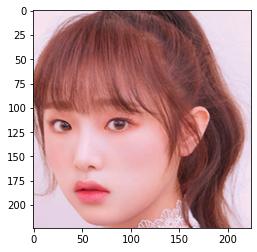

모델의 예측 :  조유리
예나 : 0%
유리 : 99%
채원 : 0%


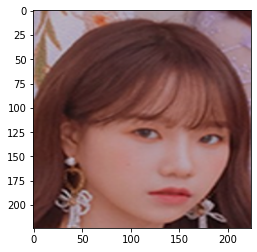

모델의 예측 :  최예나
예나 : 98%
유리 : 0%
채원 : 1%


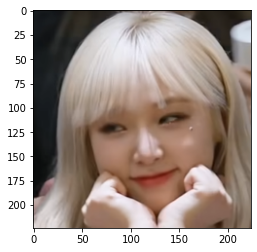

모델의 예측 :  조유리
예나 : 9%
유리 : 90%
채원 : 0%


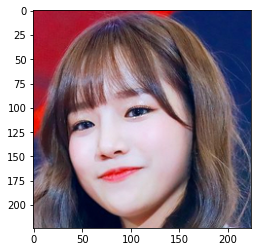

모델의 예측 :  최예나
예나 : 98%
유리 : 0%
채원 : 1%


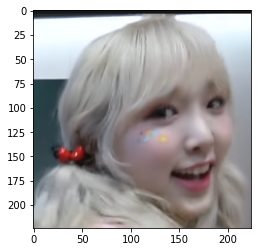

모델의 예측 :  김채원
예나 : 0%
유리 : 0%
채원 : 99%


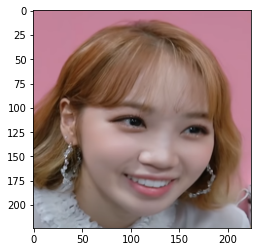

모델의 예측 :  조유리
예나 : 0%
유리 : 99%
채원 : 0%


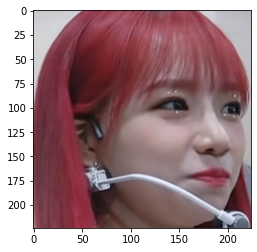

모델의 예측 :  최예나
예나 : 99%
유리 : 0%
채원 : 0%


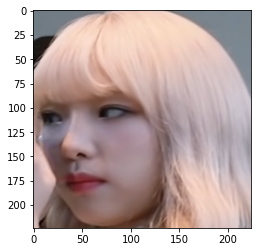

모델의 예측 :  최예나
예나 : 99%
유리 : 0%
채원 : 0%


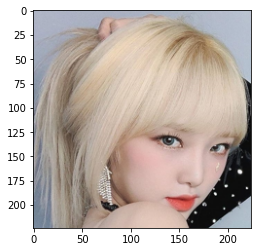

모델의 예측 :  최예나
예나 : 99%
유리 : 0%
채원 : 0%


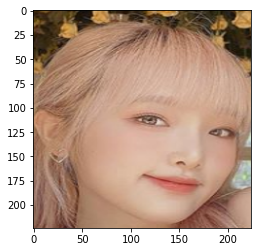

모델의 예측 :  조유리
예나 : 0%
유리 : 99%
채원 : 0%


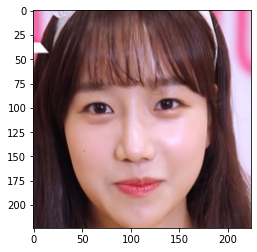

모델의 예측 :  조유리
예나 : 0%
유리 : 99%
채원 : 0%


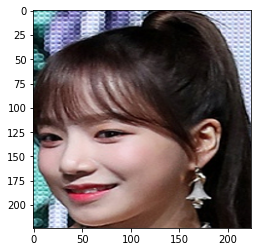

모델의 예측 :  조유리
예나 : 4%
유리 : 91%
채원 : 3%


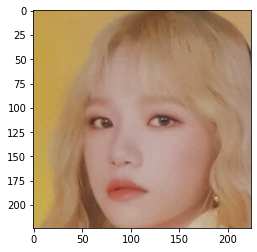

모델의 예측 :  최예나
예나 : 99%
유리 : 0%
채원 : 0%


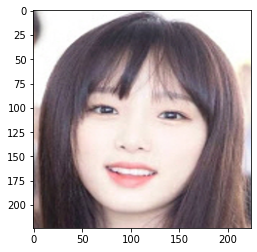

모델의 예측 :  김채원
예나 : 0%
유리 : 1%
채원 : 98%


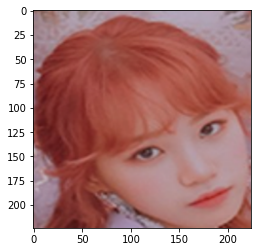

모델의 예측 :  조유리
예나 : 0%
유리 : 98%
채원 : 0%


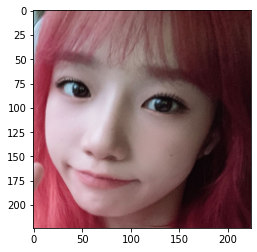

모델의 예측 :  조유리
예나 : 0%
유리 : 99%
채원 : 0%


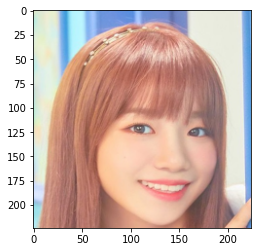

In [12]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
 
targetx = 224
targety = 224
 
test_dir = os.getcwd()+"/img/test/"
 
image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  
 
for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety,3)
    categories = ["최예나","조유리","김채원"]
    pred = model.predict(X)  
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print('모델의 예측 : ',categories[result[0]])
    print("예나 : {}%".format(int(pred[0][0]*100)))
    print("유리 : {}%".format(int(100*pred[0][1])))
    print("채원 : {}%".format(int(100*pred[0][2])))
    plt.imshow(img)
    plt.show()